In [2]:
import os
import torch
from d2l import torch as d2l

# 机器翻译

## 下载中和处理数据集

In [3]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                         '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入“英语-法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



空格替换连续空格，大写转小写，单词和标点符号之间添加空格

In [4]:
def preprocess_nmt(text):
    """预处理“英语-法语”数据集"""
    def no_space(char, pre_char):
        return char in set(',.!?') and pre_char != ' '
    
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', '').replace('\xa0', '').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
          for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


词元化

In [5]:
def tokenize_nmt(text, num_examples=None):
    """词元化“英语-法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

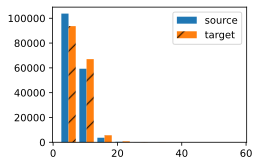

In [6]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l) for l in source],
                             [len(l) for l in target]],
                            label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right')

词汇表

In [7]:
src_vocab = d2l.Vocab(source, min_freq=2, 
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

加载数据集

In [8]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    print(line)
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    else:
        return line + [padding_token] * (num_steps - len(line))  # 填充
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4]


[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l +[ vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>'])
                         for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

build_array_nmt([['go', 'on', '!']], src_vocab, num_steps=10)

[47, 38, 126, 3]


(tensor([[ 47,  38, 126,   3,   1,   1,   1,   1,   1,   1]]), tensor([4]))

定义load_data_nmt 函数来返回数据迭代器，以及源语言和目标语言的两种词汇表

In [10]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text)
    src_vocab = d2l.Vocab(source, min_freq=2, 
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tar_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = biuld_array_nmt(source, src_vocab, num_steps)
    tar_array, tar_valid_len = biuld_array_nmt(target, tar_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tar_array, tar_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tar_vocab


## 编码器-解码器结构

编码器接口

只指定长度可变的序列作为编码器的输入X

In [11]:
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器结构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    
    def forward(self, X, *args):
        raise NotImplementedError

解码器接口

init_state 函数，用于将编码器的输出(enc_outputs)转换为编码后的状态。


In [12]:
class Decoder(nn.Module):
    """编码器-解码器结构的基本加码器接口"""
    def __init__(self, **kwargs):
        super(Decoderr, self).__init__(**kwargs)
    
    def init_state(self, enc_outputs):
        raise NotImplementedError
        
    def forward(self, X, state):
        raise NotImplementedError 

合并编码器和解码器

In [13]:
class EncoderDecoder(nn.Module):
    """编码器-解码器结构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, enc_x, dec_x, *args):
        enc_outputs = self.encoder(enc_x, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_x, dec_state)

## 序列到序列学习

In [14]:
import collections
import math
import torch
from torch import nn
from d2l import torch  as d2l

编码器

In [15]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        
    def forward(self, X):
        # 输入X的形状：（batch_size, num_steps, embed_size）
        X = self.embedding(X)
        # 维度转换为：（num_steps, batch_size, embed_size）
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        # output的形状为：（num_steps, batch_size, embed_size）
        # state[0]的形状为：（num_layers, batch_size, num_hiddens）
        return output, state

解码器

In [16]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                         dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_output, *args):
        return enc_output[1]
    
    def forward(self, X, state):
        # 输入X的形状为：（batch_size, num_steps, embed_size）
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context,使其具有X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output 的形状是：（batch_size, num_steps, vocab_size）
        # state的形状是：（num_layers, batch_size, num_hiddens）
        return output, state

In [17]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                        num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [18]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                        num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
print(state.shape)
output, state = decoder(X, state)
output.shape, state.shape

torch.Size([2, 4, 16])


(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

## 损失函数

In [19]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    max_len = X.size(1)
    mask = torch.arange((max_len), dtype=torch.float32,
                       device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X


In [20]:
X = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])
sequence_mask(X, valid_len=torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [21]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred 的形状：（batch_size, num_steps, vocab_size）
    # label 的形状：（batch_size, num_steps）
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
#         print(pred)
#         print(pred.permute(0, 2, 1))
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
#         print(unweighted_loss)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [22]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
    torch.tensor([4, 2, 0]))


tensor([2.3026, 1.1513, 0.0000])

## 训练

In [23]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    # 初始化参数，优化器，损失函数，绘图
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                           xlim=[10, num_epochs])
    
    # 批量训练
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 教师强制
            Y_hat, _ = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # 损失函数的标量进行“反传”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
f'tokens/sec on {str(device)}')

loss 0.024, 1989.7 tokens/sec on cuda:0


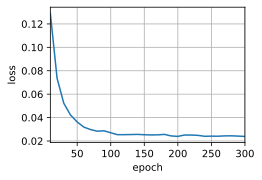

In [24]:
torch.backends.cudnn.enabled=False
batch_size, num_steps = 16, 10
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [25]:
print(torch.__version__)


1.9.1+cu102
